# This notebook is about saving final predictions and final visualization report by our final-models:
1) Improved_Multivariate_lstm_model.h5
2) xgb_ensemble_final.pkl

## Generate Final Predictions CSV

In [18]:
# Final Predictions Export
import os, joblib
import numpy as np, pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Paths
PROJECT_PATH = r"C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-"
FINAL_DIR    = os.path.join(PROJECT_PATH, "Final_Report")
os.makedirs(FINAL_DIR, exist_ok=True)

# Reload splits
LSTM_DIR     = os.path.join(PROJECT_PATH, "models", "LSTM_Models")
X_train = np.load(os.path.join(LSTM_DIR, "X_train.npy"))
X_val   = np.load(os.path.join(LSTM_DIR, "X_val.npy"))
X_test  = np.load(os.path.join(LSTM_DIR, "X_test.npy"))
y_train = np.load(os.path.join(LSTM_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(LSTM_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(LSTM_DIR, "y_test.npy"))

# Reload base models (used for ensemble meta-features)
univariate_model = load_model(
    os.path.join(LSTM_DIR, "univariate_lstm_model.h5"),
    custom_objects={"mse": MeanSquaredError()},
    compile=False
)

multivariate_model = load_model(
    os.path.join(LSTM_DIR, "multivariate_lstm_model.h5"),
    custom_objects={"mse": MeanSquaredError()},
    compile=False
)

encoder_decoder_model = load_model(
    os.path.join(LSTM_DIR, "encoder_decoder_lstm_model.h5"),
    custom_objects={"mse": MeanSquaredError()},
    compile=False
)

# Also reload new improved multivariate lstm model
improved_lstm = load_model(
    os.path.join(PROJECT_PATH, "Hyperparameter_Tuning", "Improved_Multivariate_lstm_model.h5"),
    custom_objects={"mse": MeanSquaredError()},
    compile=False
)

# Reload tuned Ensemble (XGBoost)
xgb_model = joblib.load(
    os.path.join(PROJECT_PATH, "Hyperparameter_Tuning", "xgb_ensemble_final.pkl")
)

# Predictions from base models
pred_uni   = univariate_model.predict(X_test[:, :-1, [0]], verbose=0).squeeze()
pred_multi = multivariate_model.predict(X_test, verbose=0).squeeze()
pred_seq   = encoder_decoder_model.predict(X_test, verbose=0)
pred_h1, pred_h2 = pred_seq[:, 0, 0], pred_seq[:, 1, 0]

# Meta-features
X_meta_test = np.vstack([pred_uni, pred_multi, pred_h1, pred_h2]).T
y_pred_xgb  = xgb_model.predict(X_meta_test)

# Also compute improved model preds
y_pred_imp = improved_lstm.predict(X_test, verbose=0).squeeze()

# Convert back to euro scale
y_true_euro  = np.expm1(y_test)
y_imp_euro   = np.expm1(y_pred_imp)
y_xgb_euro   = np.expm1(y_pred_xgb)

# Save to CSV
df_preds = pd.DataFrame({
    "True_Log": y_test,
    "Improved_LSTM_Log": y_pred_imp,
    "XGB_Ensemble_Log": y_pred_xgb,
    "True_Euro": y_true_euro,
    "Improved_LSTM_Euro": y_imp_euro,
    "XGB_Ensemble_Euro": y_xgb_euro
})

csv_path = os.path.join(FINAL_DIR, "Final_Predictions.csv")
df_preds.to_csv(csv_path, index=False)

print(f"\n Final predictions saved to {csv_path}")
df_preds.head()


 Final predictions saved to C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-\Final_Report\Final_Predictions.csv


,True_Log,Improved_LSTM_Log,XGB_Ensemble_Log,True_Euro,Improved_LSTM_Euro,XGB_Ensemble_Euro
0,17.504390,15.735502,16.506866,40000000.0,6820901.0,14751663.0
1,15.761421,16.150606,15.370170,7000000.0,10330446.0,4733471.5
2,17.504390,16.996790,17.461277,40000000.0,24077536.0,38312124.0
3,18.197537,17.509569,17.765760,80000000.0,40207704.0,51948344.0
4,16.523561,15.741363,14.828681,15000000.0,6860991.0,2754318.5


## Visualization

Preview of Final Predictions:


,True_Log,Improved_LSTM_Log,XGB_Ensemble_Log,True_Euro,Improved_LSTM_Euro,XGB_Ensemble_Euro
0,17.504390,15.735502,16.506866,40000000,6820901.0,14751663.0
1,15.761421,16.150606,15.370170,7000000,10330446.0,4733471.5
2,17.504390,16.996790,17.461277,40000000,24077536.0,38312124.0
3,18.197537,17.509570,17.765760,80000000,40207704.0,51948344.0
4,16.523561,15.741363,14.828681,15000000,6860991.0,2754318.5


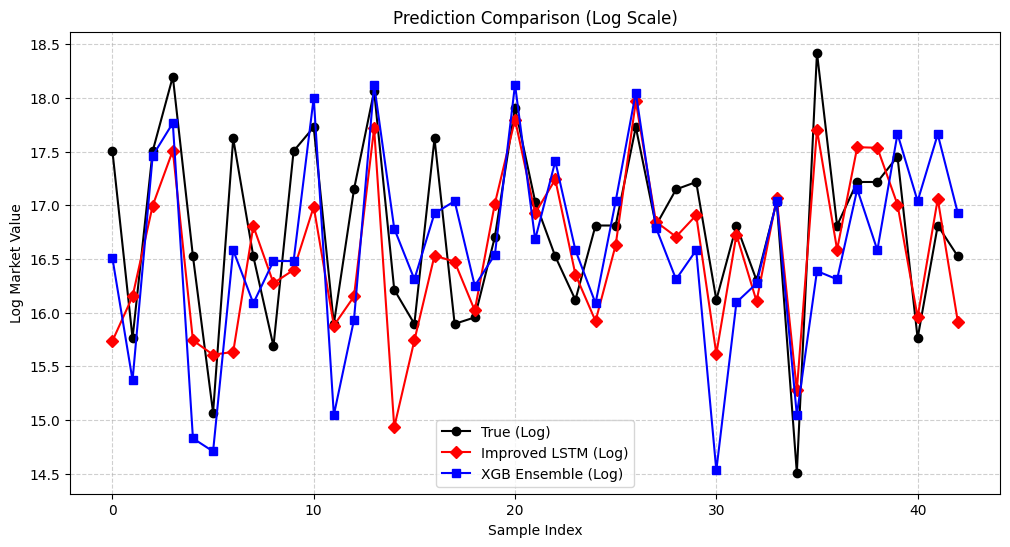

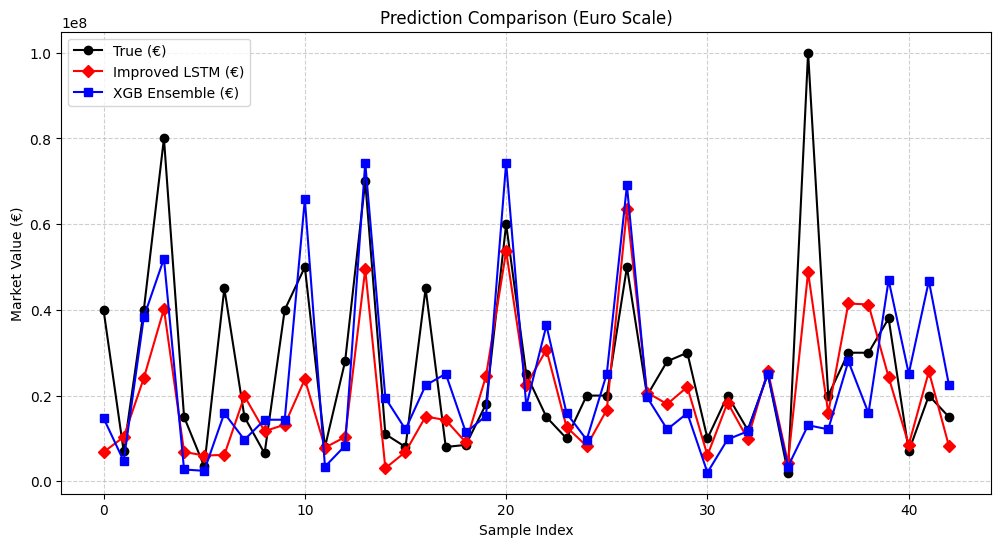

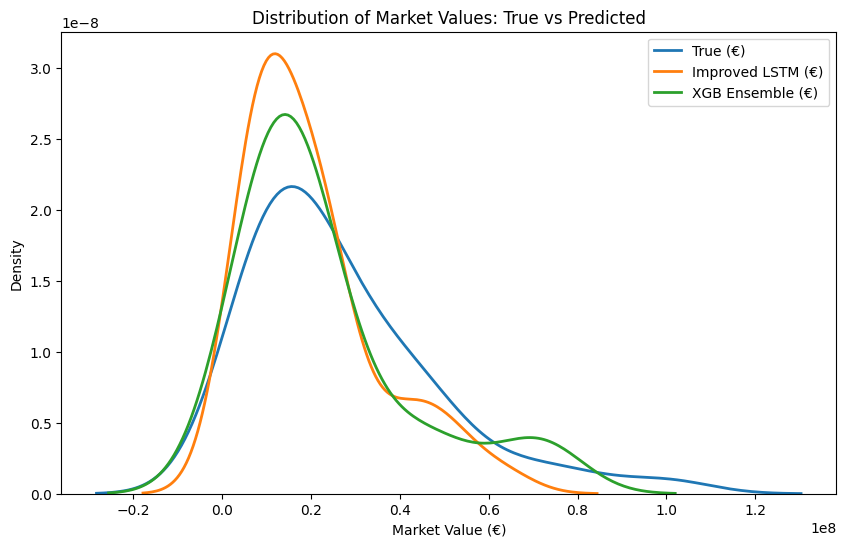

In [19]:
# Visualization of Predictions
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
PROJECT_PATH = r"C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-"
FINAL_DIR    = os.path.join(PROJECT_PATH, "Final_Report")

# Load predictions
csv_path = os.path.join(FINAL_DIR, "Final_Predictions.csv")
df_preds = pd.read_csv(csv_path)

print("Preview of Final Predictions:")
display(df_preds.head())

# Plot 1: Log-space comparison
plt.figure(figsize=(12, 6))
plt.plot(df_preds["True_Log"], "ko-", label="True (Log)")
plt.plot(df_preds["Improved_LSTM_Log"], "rD-", label="Improved LSTM (Log)")
plt.plot(df_preds["XGB_Ensemble_Log"], "bs-", label="XGB Ensemble (Log)")
plt.title("Prediction Comparison (Log Scale)")
plt.xlabel("Sample Index")
plt.ylabel("Log Market Value")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Plot 2: Euro scale comparison
plt.figure(figsize=(12, 6))
plt.plot(df_preds["True_Euro"], "ko-", label="True (€)")
plt.plot(df_preds["Improved_LSTM_Euro"], "rD-", label="Improved LSTM (€)")
plt.plot(df_preds["XGB_Ensemble_Euro"], "bs-", label="XGB Ensemble (€)")
plt.title("Prediction Comparison (Euro Scale)")
plt.xlabel("Sample Index")
plt.ylabel("Market Value (€)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# plot 3: Distribution Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df_preds["True_Euro"], label="True (€)", linewidth=2)
sns.kdeplot(df_preds["Improved_LSTM_Euro"], label="Improved LSTM (€)", linewidth=2)
sns.kdeplot(df_preds["XGB_Ensemble_Euro"], label="XGB Ensemble (€)", linewidth=2)
plt.title("Distribution of Market Values: True vs Predicted")
plt.xlabel("Market Value (€)")
plt.ylabel("Density")
plt.legend()
plt.show()


In [21]:
# Interactive Visualizations using Plotly
import plotly.graph_objects as go
import plotly.express as px

# Plot 1: Interactive Line Plot
fig = go.Figure()
fig.add_trace(go.Scatter(y=df_preds["True_Euro"], mode="lines+markers", name="True (€)", line=dict(color="black")))
fig.add_trace(go.Scatter(y=df_preds["Improved_LSTM_Euro"], mode="lines+markers", name="Improved LSTM (€)", line=dict(color="red")))
fig.add_trace(go.Scatter(y=df_preds["XGB_Ensemble_Euro"], mode="lines+markers", name="XGB Ensemble (€)", line=dict(color="blue")))

fig.update_layout(
    title="Interactive Player Transfer Value Predictions (Euro Scale)",
    xaxis_title="Sample Index",
    yaxis_title="Market Value (€)",
    hovermode="x unified",
    template="plotly_white"
)
fig.show()

# Plot 2: Interactive Distribution Plot
fig2 = px.histogram(
    df_preds.melt(
        value_vars=["True_Euro", "Improved_LSTM_Euro", "XGB_Ensemble_Euro"],
        var_name="Type",
        value_name="Market Value (€)"
    ),
    x="Market Value (€)",
    color="Type",
    barmode="overlay",
    marginal="box",
    nbins=30,
    title="Distribution of Market Values (True vs Predictions)"
)
fig2.update_traces(opacity=0.6)
fig2.show()
